# Natural Dirichlet Policy Gradients

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(['science', 'retro', 'grid'])
import pandas as pd

import sys
import os
os.environ["PATH"] += os.pathsep + '/Library/TeX/texbin'

In [3]:
from scipy.stats import dirichlet
from scipy.special import beta, gamma, digamma, polygamma

In [4]:
class GenerativeMarketEnv():

    def __init__(self, μ, Σ):
        self.μ = μ
        self.Σ = Σ
        self.best = np.argmax(μ)

    def reset(self):
        pass

    def step(self, weights):
        returns = np.random.multivariate_normal(self.μ, self.Σ)
        R = returns@weights
        return R, returns, returns[self.best]

In [10]:
class DirichletPolicy:
    
    def __init__(
        self, n_assets, α=0.001, γ=0.9,
        grad_adpt_mode='poly', returns_adpt_mode='both',
        parameterisation='linear'
    ):
        self.n_assets = n_assets
        self.θ = np.ones(self.n_assets)
        self.α = α
        self.γ = γ
        self.a_min = 1e-10
        self.a_max = 5
        self._grad_adpt_mode = grad_adpt_mode
        self._returns_adpt_mode = returns_adpt_mode
        self._parameterisation = parameterisation
    
    def act(self, X):
        a_n = self._calc_an(X)
        w_n = dirichlet.rvs(a_n)
        return w_n[0], a_n
        
        
    def grad(self, X, w):
        w[w <= 0] = 1e-10
        a_n = self._calc_an(X)
        g = (digamma(np.sum(a_n)) - digamma(a_n) + np.log(w)).T
        
        if self._parameterisation == 'linear':
             g = g @ X
        elif self._parameterisation == 'exp':
            g = g * np.exp(a_n) @ X
        elif self._parameterisation == 'softplus':
            g = g * (1/(1+np.exp(a_n))) @ X

        apt_g = self._adapt_grad(g, a_n)        
        return apt_g
    
    def discount_rewards(self, rewards):
        discounted_rewards = np.zeros_like(rewards)
        running_add = 0
        for t in reversed(range(0, len(rewards))):
            running_add = running_add * self.γ + rewards[t]
            discounted_rewards[t] = running_add
        return discounted_rewards
    
    def update(self, Xs, ws, rs):
        grads = [self.grad(*args) for args in zip(Xs, ws)]
        G = self.discount_rewards(rs)
        adpt_G = self._adapt_returns(rs, G)
        for grad, Gt in zip(grads, adpt_G):
            self.θ += self.α*(Gt)*grad
            
    def reset(self):
        self.θ = np.ones(self.n_assets)
            
    def _calc_an(self, X):
        if self._parameterisation == 'linear':
            a_n = X@self.θ
            a_n[a_n < self.a_min] = self.a_min
            a_n[a_n > self.a_max] = self.a_max
            return a_n
        elif self._parameterisation == 'exp':
            return np.exp(X@self.θ)
        elif self._parameterisation == 'softplus':
            return np.log(1 + np.exp(X@self.θ))
            
    
            
    def _adapt_grad(self, g, a_n):
        scale = 1
        if self._grad_adpt_mode == 'gamma':
            scale = np.prod(gamma(a_n))/gamma(np.sum(a_n))
        elif self._grad_adpt_mode == 'digamma':
            scale = np.prod(abs(digamma(a_n)))/abs(digamma(np.sum(a_n)))
        elif self._grad_adpt_mode == 'poly':
            scale = np.prod(polygamma(1, a_n))/sum(polygamma(1, a_n))
        elif self._grad_adpt_mode == 'di_polly_interpolation':
            scale_α = np.prod(abs(digamma(a_n)))/abs(digamma(np.sum(a_n)))
            scale_β = np.prod(polygamma(1, a_n))/sum(polygamma(1, a_n))
            scale = .5*scale_α + .5*scale_β
        elif self._grad_adpt_mode == 'max_digamma':
            scale = max(abs(digamma(a_n)))
        elif self._grad_adpt_mode == 'max_polygamma':
            scale = max(abs(polygamma(1, a_n)))
        elif self._grad_adpt_mode == 'max_di_polly_interpolation':
            scale_α = max(abs(digamma(a_n)))
            scale_β = max(abs(polygamma(1, a_n)))
            scale = .5*scale_α + .5*scale_β
        elif self._grad_adpt_mode == 'natural_gradient':
            F = np.diag(polygamma(1, a_n)) -  polygamma(1, np.sum(a_n))*np.ones((3,3))
            F_inv = np.linalg.inv(F)
            return F_inv@g
            
        return g/scale
    
    def _adapt_returns(self, rs, G):
        b = np.mean(rs)
        σ = np.mean(rs)
        if self._returns_adpt_mode == 'avg_r_baseline':
            return G-b
        elif self._returns_adpt_mode == 'noise_whitening':
            return G/(σ + 10e-10)
        elif self._returns_adpt_mode == 'both':
            return (G-b)/(σ + 10e-10)
        else:
            return G
        
            
        

In [11]:
class Harness:
    
    def __init__(self, env, policy):
        self._env = env
        self._policy = policy
        
        self.hist = {
            'states': [],
            'rewards': [],          
            'ep_rewards': [],
            'best_ep_rewards': [],
            'ws': [],
            'a_ns': [],
            'γ': policy.γ,
            'α': policy.α
            
        }
    
    def _generate_episode(self):
        state = self._env.reset()
        
        ep_reward = 0
        best_ep_reward = 0
        ws = []
        rewards = []
        states = []
        
        for i in range(50):
            
    
            X = np.eye(self._policy.n_assets)
            w, a = self._policy.act(X)
    
            
            R, rs, best_r = self._env.step(w)      
            
            ep_reward += R
            best_ep_reward += best_r
            rewards.append(R)
            states.append(X)
            ws.append(w)
            
        self.hist['states'].append(states)
        self.hist['rewards'].append(rewards)
        self.hist['ws'].append(ws)
        self.hist['a_ns'].append(a)
        self.hist['ep_rewards'].append(ep_reward)
        self.hist['best_ep_rewards'].append(best_ep_reward)
        
        return np.array(states), np.array(rewards)
    
    def train(self, num_episodes=1000):
        self._policy.reset()
 
        for i in range(num_episodes):

            # run a single episode
            self._generate_episode()

            # update policy
            self._policy.update(self.hist['states'][i], self.hist['ws'][i], self.hist['rewards'][i])

    
    
    def plot_smooth_rewards(self, eps, window=10, file_name=None):
        rs = np.array(pd.Series(self.hist['ep_rewards']).rolling(window).mean()[window - 1:])
        plt.figure(figsize=(8, 6), dpi=100)
        plt.plot(np.arange(eps-(window-1)), rs)
        plt.ylabel('Total Returns')
        plt.xlabel('Episode')
        plt.hlines(150, 0, eps-(window-1), linestyles='dashed', colors='red')
#         plt.plot(np.arange(eps), self.hist['best_ep_rewards'])
        if file_name:
            plt.savefig('./report_images/{}'.format(file_name))
        
    def plot_weights_vs_ep(self, eps):
        av_weights = np.array(self.hist['ws']).mean(axis=1)
        wn_over_time = list(zip(*av_weights))
        plt.figure(figsize=(8, 6), dpi=100)
        plt.plot(wn_over_time[0], label='Asset 1 weighting')
        plt.plot(wn_over_time[1], label='Asset 2 weighting')
        plt.plot(wn_over_time[2], label='Asset 3 weighting')
        plt.title('Average Weighting For Each Episode')
        plt.xlabel('Episode')
        plt.ylabel('Asset Weighting')
        plt.legend()
        
    def plot_episode_weights(self, ep):
        final_weights = list(zip(*np.array(self.hist['ws'])[ep-1][3:]))
        plt.figure(figsize=(8, 6), dpi=100)
        plt.plot(final_weights[0], linewidth=1.5, label='Asset 1 weighting')
        plt.plot(final_weights[1], linewidth=1.5, label='Asset 2 weighting')
        plt.plot(final_weights[2], linewidth=1.5, label='Asset 3 weighting')
        plt.title('Final Episode Weights')
        plt.xlabel('Time Step')
        plt.ylabel('Asset Weighting');
        plt.legend()

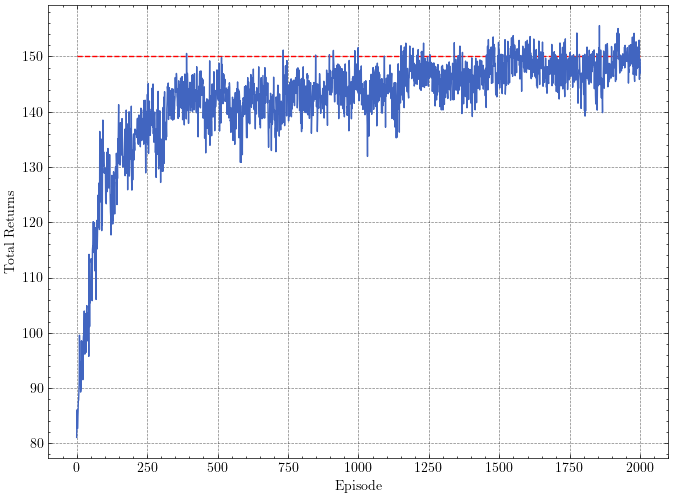

In [26]:
env = GenerativeMarketEnv([1, 3, 1], [[.1, 0, 0], [0, .1, 0], [0, 0, .1] ])
policy = DirichletPolicy(
    3,  α=2e-2, γ=0.7,
    grad_adpt_mode='natural_gradient', returns_adpt_mode='both',
    parameterisation='softplus'
)
harness = Harness(env, policy)
eps = 2000
harness.train(num_episodes=eps)
harness.plot_smooth_rewards(eps, window=1)

# Parallel Runner 

In [38]:
from collections import defaultdict
from joblib import Parallel, delayed
from tqdm import tqdm

In [39]:
class ParallelRunner:
    
    def __init__(self, n_runs, params):
        self._n_runs = n_runs
        self._params = params
        self.results = defaultdict(list)
        
    def run(self):
        arr = []
        for i, param in tqdm(enumerate(self._params)):
            rs = Parallel(n_jobs=10, backend='loky')(delayed(self.single_run)(param) for i in tqdm(range(self._n_runs)))
            arr.append(rs)
        for i, r in enumerate(arr):
            self.results[str(i)] = r
             
        
    def single_run(self, params):
        e = GenerativeMarketEnv([1, 3, 1], [[.1, 0, 0], [0, .1, 0], [0, 0, .1]])
        p = DirichletPolicy(*list(params.values())[:-1])
        h = Harness(e, p)
        h.train(num_episodes=params['eps'])
    
        return h.hist
    
    def plot_av_reward_for_run(self, key):
        
        ep_rewards  = []
        plt.figure(figsize=(8, 6), dpi=100)
        for r in self.results[key]:
            ep_rewards.append(r['ep_rewards'])
        ep_rewards = np.array(ep_rewards)
        
        plt.figure(figsize=(8, 6), dpi=100)
        mean = ep_rewards.mean(axis=0)
        std  = ep_rewards.std(axis=0)
        
        
        plt.plot(np.arange(ep_rewards.shape[1]), mean)
        plt.hlines(150, 0, ep_rewards.shape[1], linestyles='dashed', colors='red')
        plt.fill_between(np.arange(ep_rewards.shape[1]), mean - std, mean + std, alpha=0.6)
        
    def plot_av_rewards(self, window=1, file_name=None):
        d = {'0': 'both', '1': 'avg. rewards', '2': 'noise whitening'}
        plt.figure(figsize=(8, 6), dpi=100)
        for key in self.results:
            ep_rewards  = []
            for r in self.results[key]:
                ep_rewards.append(r['ep_rewards'])
            ep_rewards = np.array(ep_rewards)
            
            
            mean = ep_rewards.mean(axis=0)
            std  = ep_rewards.std(axis=0)
            
            smooth_mean = np.array(pd.Series(mean).rolling(window).mean()[window - 1:])
            
            plt.plot(np.arange(ep_rewards.shape[1] - (window-1)), smooth_mean, label='{}'.format(
#                 p_runner.results[key][0]['grad_adpt_mode'],
                d[key]
            ))
            plt.fill_between(np.arange(ep_rewards.shape[1]), mean - std, mean + std, alpha=0.6)
        
        plt.legend()
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.hlines(150, 0, ep_rewards.shape[1], linestyles='dashed', colors='red')
        if file_name:
            plt.savefig('./report_images/{}'.format(file_name))

In [42]:
params_1 = {
    'n_assets': 3,
    'α': 1e-1,
    'γ': .7,
    'grad_adpt_mode': 'max_polygamma',
    'returns_adpt_mode': 'both',
    'parameterisation': 'softplus',
    'eps': 3000
}

params_2 = {
    'n_assets': 3,
    'α': 2e-2,
    'γ': .7,
    'grad_adpt_mode': 'natural_gradient',
    'returns_adpt_mode': 'both',
    'parameterisation': 'softplus',
    'eps': 3000
}

params = [params_1, params_2]

In [43]:
p_runner = ParallelRunner(10, params)
p_runner.run()

0it [00:00, ?it/s]
100%|██████████| 10/10 [00:00<00:00, 30.96it/s]
1it [01:38, 98.65s/it]
100%|██████████| 10/10 [00:00<00:00, 5997.86it/s]
2it [03:39, 109.96s/it]


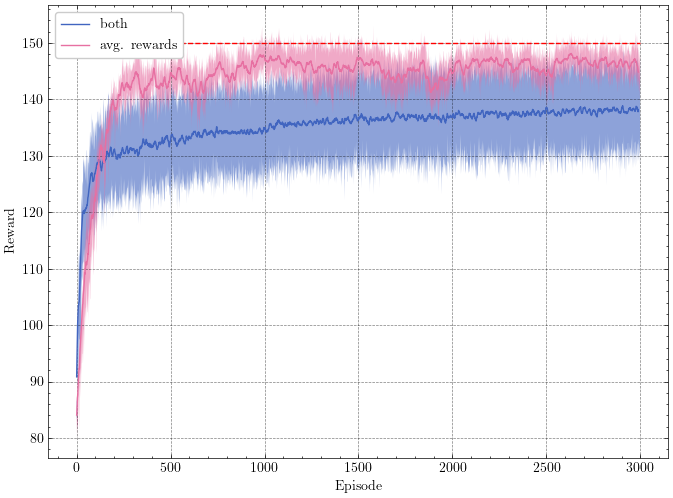

In [45]:
p_runner.plot_av_rewards(window=10)

In [71]:
a,b, c = list(zip(*p_runner.results['1'][0]['a_ns']))

In [72]:
max(b)

18.49440852658381

In [73]:
np.mean(b)

3.6713191774841416

In [68]:
a,b, c = list(zip(*p_runner.results['0'][0]['a_ns']))

In [69]:
max(b)

2.0467866649692152

In [70]:
np.mean(b)

2.0382173607004375

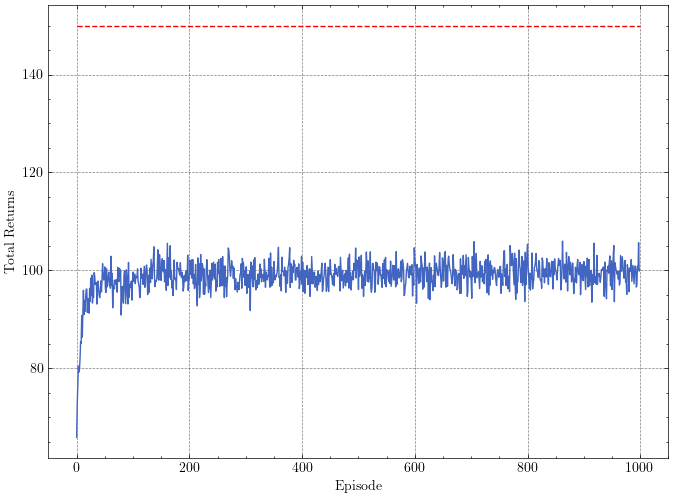

In [86]:
env = GenerativeMarketEnv([1, 2, 1], [[.1, 0, 0], [0, .1, 0], [0, 0, .1] ])
policy = DirichletPolicy(
    3,  α=4e-1, γ=0.1,
    grad_adpt_mode='natural_gradient', returns_adpt_mode='both',
    parameterisation='softplus'
)
harness = Harness(env, policy)
eps = 1000
harness.train(num_episodes=eps)
harness.plot_smooth_rewards(eps, window=1)

In [87]:
harness.hist['a_ns'][999]

array([0.02361453, 5.55356335, 0.01820159])

In [89]:
not False / ((not False) + True)

True

In [90]:
params_1 = {
    'n_assets': 3,
    'α': 9e-4,
    'α_end': 9e-4,
    'start_ep': 9999, 
    'α_decay_steps': 9999,
    'γ': 0.6,
    'grad_adpt_mode': 'max_digamma',
    'returns_adpt_mode': None,
    'parameterisation': 'softplus',
    'eps': 2000
}

params_2 = {
    'n_assets': 3,
    'α': 4e-2,
    'α_end': 4e-2,
    'start_ep': 9999, 
    'α_decay_steps': 9999,
    'γ': 0.6,
    'grad_adpt_mode': 'max_polygamma',
    'returns_adpt_mode': None,
    'parameterisation': 'softplus',
    'eps': 2000
}

params_3 = {
    'n_assets': 3,
    'α': 9e-3,
    'α_end': 9e-3,
    'start_ep': 9999, 
    'α_decay_steps': 9999,
    'γ': 0.6,
    'grad_adpt_mode': 'max_di_polly_interpolation',
    'returns_adpt_mode': None,
    'parameterisation': 'softplus',
    'eps': 2000
}


legend_labels = {
    '0': r'digamma', 
    '1': r'polygamma',
    '2': r'interpolation',
}


params = [params_1, params_2, params_3]

In [100]:
np.sum(dirichlet.var([0.1, 2, 0.1]))

0.052944214876033076